In [4]:
from sctoolbox.utilities import bgcolor

# Batch effect correction and comparisons
<hr style="border:2px solid black"> </hr>

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [5]:
%bgcolor PowderBlue

#####################DEFINING TEST NUMBER##############################
test = "Test1"

################DEFINING THE NUMBER OF CORES TO USE####################
threads = 10

# Options for highly variable genes
min_limit = 1000
max_limit = 5000

# Should preliminary clustering be performed?
do_clustering = True #True or False

######## BATCH CORRECTIONS ###########
batch_column = "batch"
perform_batch_correction = True
batch_methods = ["bbknn", "combat", "mnn", "harmony", "scanorama"]

###################DEFINING COLLORS AND FIGURE PATH####################
color_list=['green', 'red', 'blue', 'pink', 'chartreuse', 'gray', 'yellow', 'brown', 'purple', 'orange', 'wheat', 'lightseagreen', 'cyan', 'khaki', 'cornflowerblue', 'olive', 'gainsboro', 'darkmagenta', 'slategray', 'ivory', 'darkorchid', 'papayawhip', 'paleturquoise', 'oldlace', 'orangered', 'lavenderblush', 'gold', 'seagreen', 'deepskyblue', 'lavender', 'peru', 'silver', 'midnightblue', 'antiquewhite', 'blanchedalmond', 'firebrick', 'greenyellow', 'thistle', 'powderblue', 'darkseagreen', 'darkolivegreen', 'moccasin', 'olivedrab', 'mediumseagreen', 'lightgray', 'darkgreen', 'tan', 'yellowgreen', 'peachpuff', 'cornsilk', 'darkblue', 'violet', 'cadetblue', 'palegoldenrod', 'darkturquoise', 'sienna', 'mediumorchid', 'springgreen', 'darkgoldenrod', 'magenta', 'steelblue', 'navy', 'lightgoldenrodyellow', 'saddlebrown', 'aliceblue', 'beige', 'hotpink', 'aquamarine', 'tomato', 'darksalmon', 'navajowhite', 'lawngreen', 'lightsteelblue', 'crimson', 'mediumturquoise', 'mistyrose', 'lightcoral', 'mediumaquamarine', 'mediumblue', 'darkred', 'lightskyblue', 'mediumspringgreen', 'darkviolet', 'royalblue', 'seashell', 'azure', 'lightgreen', 'fuchsia', 'floralwhite', 'mintcream', 'lightcyan', 'bisque', 'deeppink', 'limegreen', 'lightblue', 'darkkhaki', 'maroon', 'aqua', 'lightyellow', 'plum', 'indianred', 'linen', 'honeydew', 'burlywood', 'goldenrod', 'mediumslateblue', 'lime', 'lightslategray', 'forestgreen', 'dimgray', 'lemonchiffon', 'darkgray', 'dodgerblue', 'darkcyan', 'orchid', 'blueviolet', 'mediumpurple', 'darkslategray', 'turquoise', 'salmon', 'lightsalmon', 'coral', 'lightpink', 'slateblue', 'darkslateblue', 'white', 'sandybrown', 'chocolate', 'teal', 'mediumvioletred', 'skyblue', 'snow', 'palegreen', 'ghostwhite', 'indigo', 'rosybrown', 'palevioletred', 'darkorange', 'whitesmoke']

<hr style="border:2px solid black"> </hr>

## Set up

In [6]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

import sctoolbox.utilities as utils
import sctoolbox.annotation as an
import sctoolbox.plotting as pl
import sctoolbox.analyser as analyser

## Loading the anndata

In [7]:
adata = utils.load_anndata(is_from_previous_note=True, which_notebook=2)
display(adata)

AnnData object with n_obs × n_vars = 2738 × 21128
    obs: 'orig.ident', 'chamber', 'donor', 'batch', 'sample', 'celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_is_ribo', 'log1p_total_counts_is_ribo', 'pct_counts_is_ribo', 'total_counts_is_mito', 'log1p_total_counts_is_mito', 'pct_counts_is_mito', 'total_counts_is_gender', 'log1p_total_counts_is_gender', 'pct_counts_is_gender', 'predicted_sex'
    var: 'is_ribo', 'is_mito', 'cellcycle', 'is_gender', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'color_set', 'infoprocess'

In [8]:
data_to_evaluate = adata.uns['infoprocess']['data_to_evaluate']
adata.uns[data_to_evaluate + '_colors'] = color_list

In [9]:
figure_path = adata.uns["infoprocess"]["Anndata_path"] + "/"

## Normalization

In [10]:
sc.pp.normalize_total(adata, target_sum=None, exclude_highly_expressed=True)
sc.pp.log1p(adata)

## Find highly variable genes

In [11]:
an.annot_HVG(adata, hvg_range=(min_limit, max_limit))

Annotating highy variable genes (HVG)


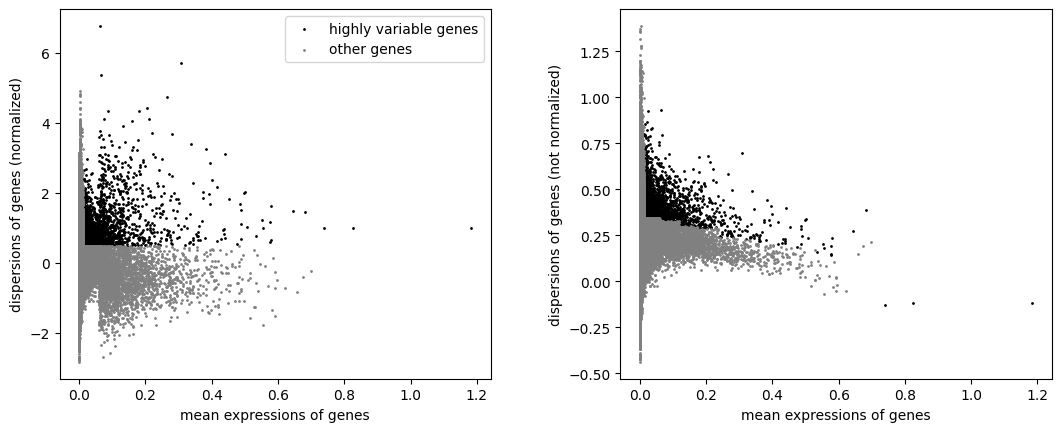

In [12]:
sc.pl.highly_variable_genes(adata, show=False)
utils.save_figure(figure_path + "highly_variable.pdf")

In [13]:
#Number of variable genes selected
adata.var["highly_variable"].sum()

2571

## PCA and neighbors for uncorrected data

In [14]:
sc.pp.pca(adata, svd_solver='arpack', n_comps=50, use_highly_variable=True)

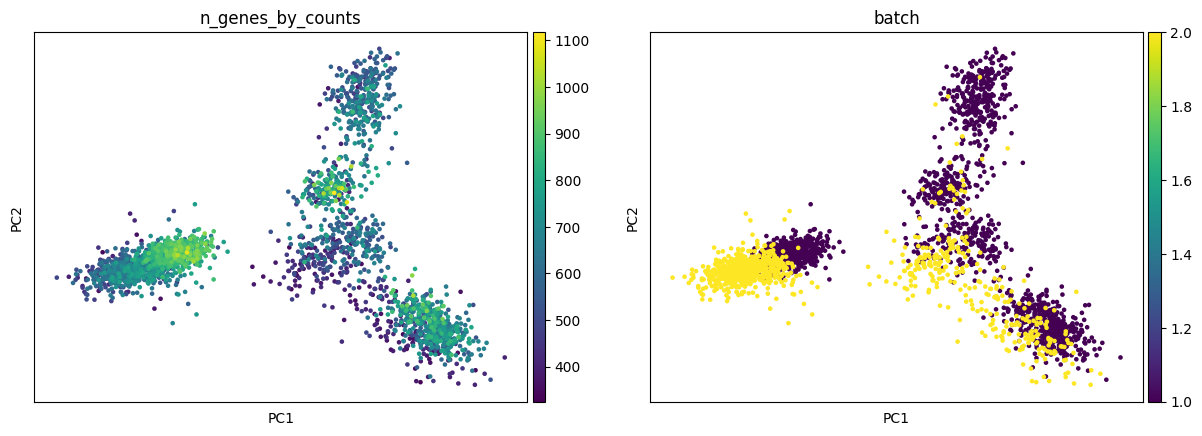

In [15]:
sc.pl.pca(adata, color=['n_genes_by_counts', batch_column], show=False)
utils.save_figure(figure_path + "PCA.pdf")

In [16]:
sc.pp.neighbors(adata)

## Batch correction (optional)

In [17]:
adata.obs[batch_column] = adata.obs[batch_column].astype("category") #ensure that batch column is a category

In [18]:
if perform_batch_correction:
    batch_corrections = analyser.wrap_corrections(adata, 
                                              batch_key=batch_column,
                                              methods=batch_methods)
else:
    batch_corrections = {"uncorrected": adata}

Running batch correction with 'bbknn'...
Running batch correction with 'combat'...


/home/mbentse/.conda/envs/sctoolbox/lib/python3.10/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Running batch correction with 'mnn'...
Running batch correction with 'harmony'...
Running batch correction with 'scanorama'...
[[0.        0.8706721]
 [0.        0.       ]]
Processing datasets 1 <=> 2
Finished batch correction(s)!


### Plot overview of batch corrections

In [19]:
color_by = [batch_column, "total_counts"]

In [20]:
#Run standard umap for all adatas
analyser.wrap_umap(batch_corrections.values(), threads=threads)

Computing UMAPs :   0%|          | 0/6 [00:00<?, ?it/s]

### Choosing the correct anndata for downstream analysis:

##### wrap_batch_evaluation:
the following function evaluates batch correction methods for each of the anndata objects in 'batch_corrections' based on #LISI_score.

##### LISI score:
LISI score (stored in adata.obs) indicates the effective number of different categories represented in the local neighborhood of each cell. If the cells are well-mixed, then we expect the LISI score to be closer to n for a data with n batches.

##### The higher the LISI score is, the better batch correction method worked to normalize the batch effect and mix the cells from different batches.



In [21]:
#Perform additional clustering if it was chosen
if do_clustering:
    for adata in batch_corrections.values():
        sc.tl.leiden(adata)
    color_by.append("leiden")

In [22]:
# Calculate LISI scores for batch
analyser.wrap_batch_evaluation(batch_corrections, batch_key=batch_column, threads=threads, inplace=True)

Calculating LISI scores:   0%|          | 0/12 [00:00<?, ?it/s]

The final decision has to be made by the user about which anndata to take for downstream analysis.

Higher LISI score means better batch correction, but you also need to consider the following PCA and UMAP and see how the distribution of batches and other factors (such as clusters) look like, after correction compared with uncorrected data.

The following function computes and draws the required plots for this decision.

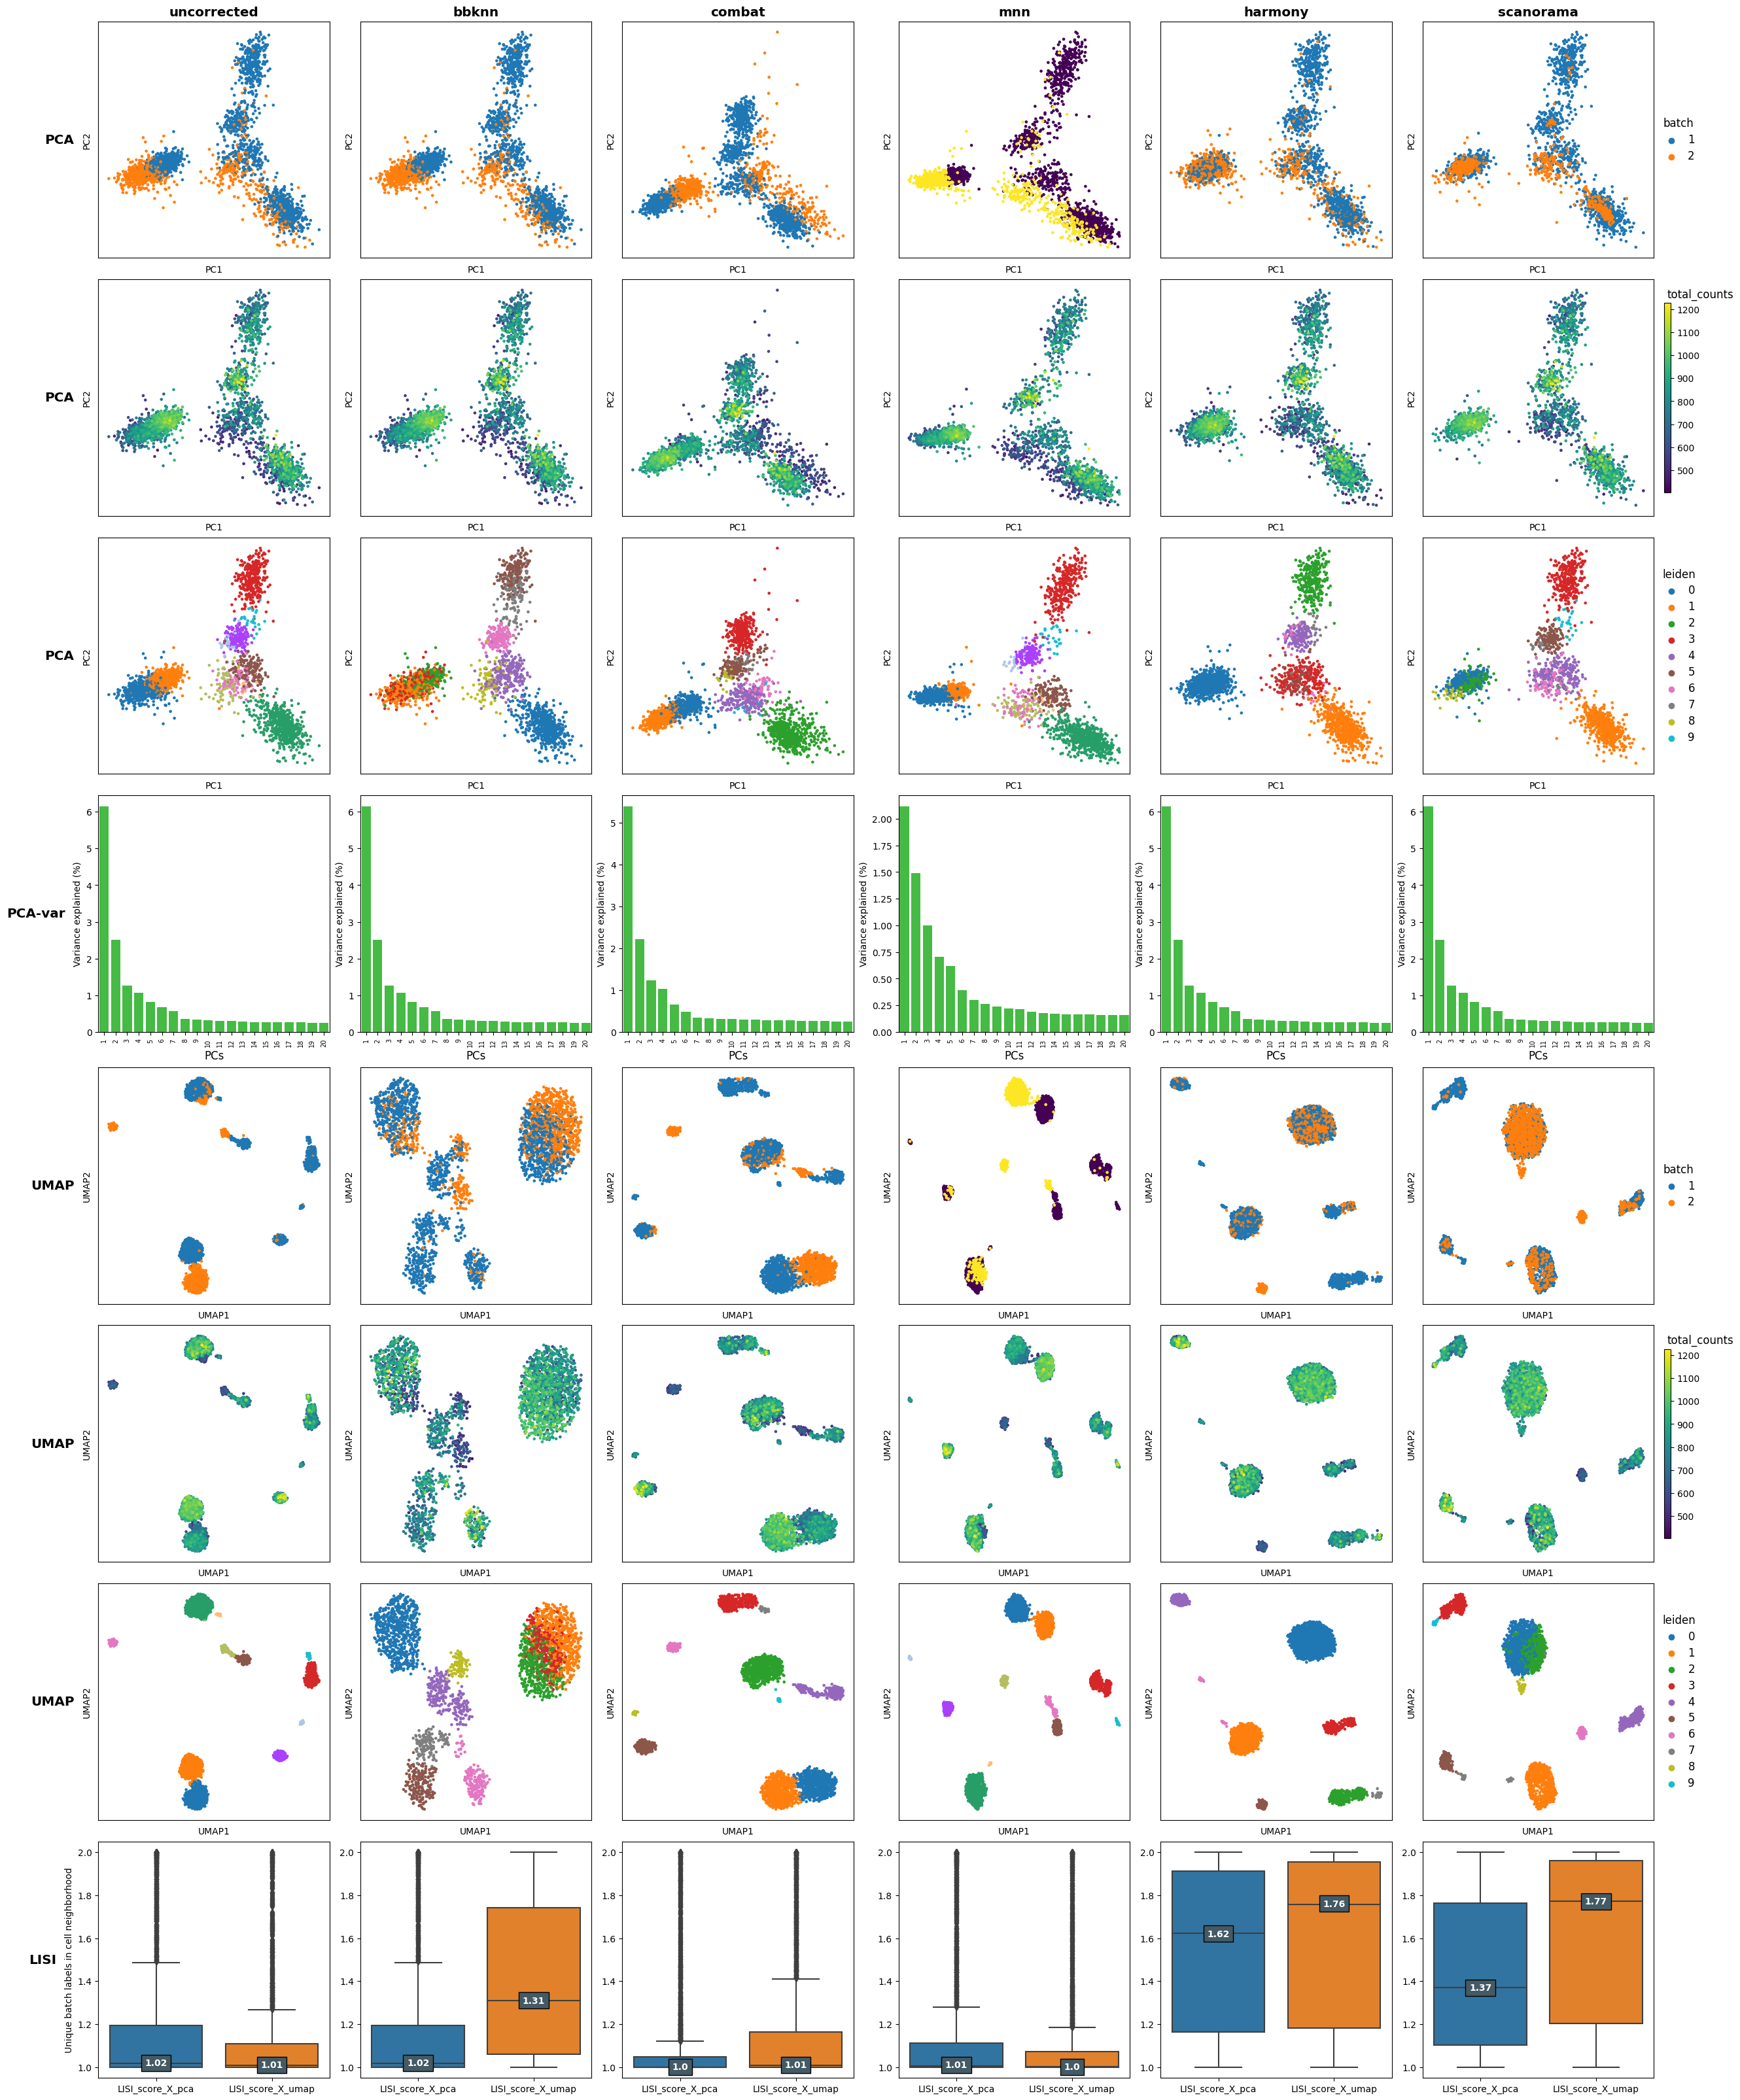

In [23]:
#Plot the overview of batch correction methods
_ = pl.anndata_overview(batch_corrections, color_by=color_by, 
                        output=figure_path + "batch_correction_overview.pdf")

### Select the final object

In [24]:
%bgcolor PowderBlue

selected = "scanorama"

In [25]:
if selected not in batch_corrections:
    raise KeyError(f"'{selected}' is not a key in batch_corrections")

In [26]:
adata = batch_corrections[selected]

## Saving adata for next notebook

In [27]:
adata

AnnData object with n_obs × n_vars = 2738 × 21128
    obs: 'orig.ident', 'chamber', 'donor', 'batch', 'sample', 'celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_is_ribo', 'log1p_total_counts_is_ribo', 'pct_counts_is_ribo', 'total_counts_is_mito', 'log1p_total_counts_is_mito', 'pct_counts_is_mito', 'total_counts_is_gender', 'log1p_total_counts_is_gender', 'pct_counts_is_gender', 'predicted_sex', 'leiden', 'LISI_score_X_pca', 'LISI_score_X_umap'
    var: 'is_ribo', 'is_mito', 'cellcycle', 'is_gender', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'color_set', 'infoprocess', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'batch_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [28]:
utils.saving_anndata(adata, current_notebook=3)

Your new anndata object is saved here: pipeline_output/results/Test1/anndata_3_Test1.h5ad
